# Imports

In [1]:
!pip install pytabkit    

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.0/364.0 kB 7.7 MB/s eta 0:00:00


In [2]:
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from pytabkit import RealMLP_TD_Classifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

warnings.filterwarnings('ignore')

# Global Configuration

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_STATE = 42
N_FOLDS = 5

print(f"Using device: {DEVICE}")

Using device: cuda


# Data Loading and Preprocessing

In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s6e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s6e2/test.csv")
original = pd.read_csv("/kaggle/input/heartdisease/Heart_Disease_Prediction.csv") 

le = LabelEncoder()
train['Heart Disease'] = le.fit_transform(train['Heart Disease'])
original['Heart Disease'] = le.fit_transform(original['Heart Disease'])

base_features = [col for col in train.columns if col not in ['Heart Disease', 'id']] 

def add_engineered_features(df):
    df_temp = df.copy()
    
    for col in base_features: 
        if col in original.columns:
           
            stats = original.groupby(col)['Heart Disease'].agg(['mean', 'median', 'std', 'skew', 'count']).reset_index()
         
            stats.columns = [col] + [f"orig_{col}_{s}" for s in ['mean', 'median', 'std', 'skew', 'count']]
     
            df_temp = df_temp.merge(stats, on=col, how='left') 
 
            fill_values = {
                f"orig_{col}_mean": original['Heart Disease'].mean(),
                f"orig_{col}_median": original['Heart Disease'].median(),
                f"orig_{col}_std": 0,
                f"orig_{col}_skew": 0,
                f"orig_{col}_count": 0
            }
            df_temp = df_temp.fillna(value=fill_values)
            
    return df_temp

train = add_engineered_features(train)
test = add_engineered_features(test) 

X = train.drop(['id', 'Heart Disease'], axis=1)
y = train['Heart Disease']
X_test = test.drop(['id'], axis=1)

# Data Quality Check (Missing & Duplicates)

In [5]:
def check_data_quality(df, name="Dataset"):
    print(f"--- Data Quality: {name} ---")
    print(f"Total Rows: {len(df)}")

    cols_to_check = [c for c in df.columns if c != 'id']
    dupes = df.duplicated(subset=cols_to_check).sum()

    nan_counts = df.isnull().sum()
    total_nans = nan_counts.sum()
    
    print(f"Duplicate Rows (excl. ID): {dupes}")
    print(f"Total NaN values: {total_nans}")
    if total_nans > 0:
        print("\nColumns with NaNs:")
        print(nan_counts[nan_counts > 0])
    print("-" * 30)

check_data_quality(train, "Train")
check_data_quality(test, "Test")

--- Data Quality: Train ---
Total Rows: 630000
Duplicate Rows (excl. ID): 0
Total NaN values: 0
------------------------------
--- Data Quality: Test ---
Total Rows: 270000
Duplicate Rows (excl. ID): 0
Total NaN values: 0
------------------------------


# Feature Uniqueness & Cardinality

In [6]:
def analyze_uniqueness(df):
    unique_stats = []
    for col in df.columns:
        if col == 'id': continue
        
        n_unique = df[col].nunique()
        dtype = df[col].dtype

        category_guess = "Categorical/Ordinal" if n_unique < 25 else "Continuous"
        
        unique_stats.append({
            'Feature': col,
            'Unique Values': n_unique,
            'Data Type': dtype,
            'Heuristic Type': category_guess
        })
    
    return pd.DataFrame(unique_stats).sort_values(by='Unique Values')

uniqueness_df = analyze_uniqueness(train)
print(uniqueness_df)

                     Feature  Unique Values Data Type       Heuristic Type
40  orig_FBS over 120_median              1   float64  Categorical/Ordinal
1                        Sex              2     int64  Categorical/Ordinal
13             Heart Disease              2     int64  Categorical/Ordinal
5               FBS over 120              2     int64  Categorical/Ordinal
20           orig_Sex_median              2   float64  Categorical/Ordinal
..                       ...            ...       ...                  ...
0                        Age             42     int64           Continuous
3                         BP             66     int64           Continuous
9              ST depression             66   float64           Continuous
7                     Max HR             93     int64           Continuous
4                Cholesterol            150     int64           Continuous

[79 rows x 4 columns]


# Visualize Top Skewed Features

Top 6 Most Skewed Features (Absolute Values):
orig_EKG results_count   -15.613416
orig_EKG results_std       6.747575
orig_Slope of ST_count    -5.657311
orig_Thallium_std          4.472673
orig_BP_std               -4.174508
orig_Age_std              -3.145546
dtype: float64


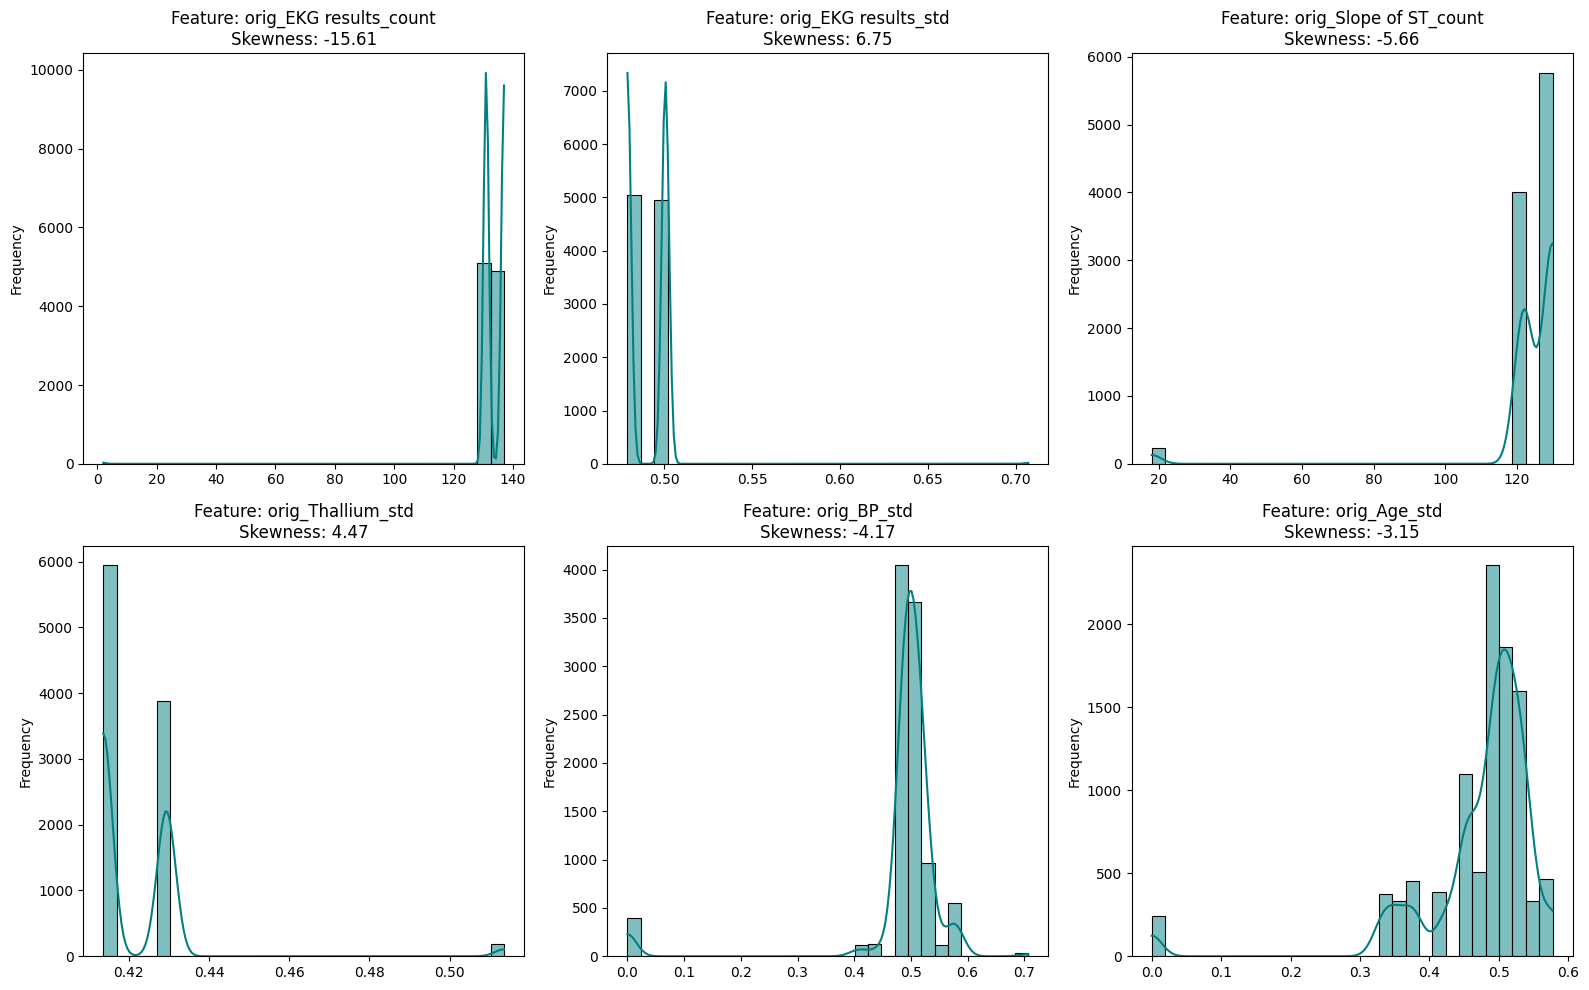

In [7]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

skew_series = X[numeric_cols].skew().abs().sort_values(ascending=False)
top_skewed_features = skew_series.head(6).index.tolist()

print("Top 6 Most Skewed Features (Absolute Values):")
print(X[top_skewed_features].skew())

plt.figure(figsize=(16, 10))
for i, col in enumerate(top_skewed_features):
    plt.subplot(2, 3, i + 1) 
    sns.histplot(X[col].sample(min(10000, len(X))), kde=True, color='teal', bins=30)
    plt.title(f"Feature: {col}\nSkewness: {X[col].skew():.2f}")
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig('skewed_distributions.png')

In [8]:
# --- Medical Feature Engineering based on NEJM Paper Insights ---
# Paper: "Global Effect of Cardiovascular Risk Factors on Lifetime Estimates"
# Key insights:
# 1. Presence of 5 classic risk factors (Hypertension, Hyperlipidemia, Diabetes, Smoking, Obesity) drastically reduces life-years.
# 2. Modifying hypertension/risk factors at age 55-60 yields the highest benefit.
# 3. Risk profiles differ significantly by Sex (Men have higher baseline risk).

def add_medical_paper_features(df):
    df_eng = df.copy()

    # --- 1. Define Binary Risk Factors (Thresholds) ---
    # Although the dataset lacks Smoking/Obesity, we use the available clinical markers.
    # Hypertension: BP >= 140 is a standard medical threshold for high risk.
    df_eng['Risk_High_BP'] = (df_eng['BP'] >= 140).astype(int)

    # Hyperlipidemia: Cholesterol >= 240 is considered high risk.
    df_eng['Risk_High_Chol'] = (df_eng['Cholesterol'] >= 240).astype(int)

    # Diabetes: Already present as 'FBS over 120'
    df_eng['Risk_Diabetes'] = df_eng['FBS over 120']

    # --- 2. Cumulative Risk Burden ---
    # The paper notes "presence of all five risk factors" vs "none".
    # We sum our available factors to create a 'Risk Burden Score' (0 to 3).
    df_eng['Risk_Burden_Score'] = (
        df_eng['Risk_High_BP'] +
        df_eng['Risk_High_Chol'] +
        df_eng['Risk_Diabetes']
    )

    # --- 3. Critical Age Window (55-60) ---
    # Insight: "Modification of hypertension at an age of 55 to less than 60 years was associated with the most additional life-years."
    # We flag this specific age window.
    df_eng['Age_Window_55_60'] = ((df_eng['Age'] >= 55) & (df_eng['Age'] < 60)).astype(int)

    # Interaction: Having High BP specifically during this critical window is a strong negative signal.
    df_eng['Critical_Age_Hypertension'] = df_eng['Age_Window_55_60'] * df_eng['Risk_High_BP']

    # --- 4. Midlife Risk Baseline (Age 50) ---
    # Insight: "Absence of risk factors at 50 years of age was associated with... greater life expectancy."
    # We establish a baseline flag for being 50 or older.
    df_eng['Age_50_Plus'] = (df_eng['Age'] >= 50).astype(int)

    # Interaction: Impact of risk burden for those over 50.
    df_eng['Age50_Risk_Interaction'] = df_eng['Age_50_Plus'] * df_eng['Risk_Burden_Score']

    # --- 5. Gender-Specific Risk Interaction ---
    # Insight: "Lifetime risk... was 24% among women and 38% among men."
    # Male sex implies a higher baseline risk slope for the same number of risk factors.
    # We capture this by interacting Sex with the Risk Score.
    df_eng['Sex_Risk_Interaction'] = df_eng['Sex'] * df_eng['Risk_Burden_Score']

    return df_eng

# Apply the engineering to both Train and Test sets
X = add_medical_paper_features(X)
X_test = add_medical_paper_features(X_test)

# --- Important: Define New Features as Categorical ---
# Since these are binary flags or small integer counts, they work best with Entity Embedding (Category) in RealMLP.
new_medical_features = [
    'Risk_High_BP', 'Risk_High_Chol', 'Risk_Diabetes', 'Risk_Burden_Score',
    'Age_Window_55_60', 'Critical_Age_Hypertension',
    'Age_50_Plus', 'Age50_Risk_Interaction', 'Sex_Risk_Interaction'
]

# Ensure they are treated as categorical strings for the model
for col in new_medical_features:
    X[col] = X[col].astype(str).astype('category')
    X_test[col] = X_test[col].astype(str).astype('category')

print(f"Added {len(new_medical_features)} new medical features based on NEJM paper insights.")
print(X[new_medical_features].head())

Added 9 new medical features based on NEJM paper insights.
  Risk_High_BP Risk_High_Chol Risk_Diabetes Risk_Burden_Score  \
0            1              0             0                 1   
1            0              1             0                 1   
2            1              0             0                 1   
3            0              0             0                 0   
4            1              0             0                 1   

  Age_Window_55_60 Critical_Age_Hypertension Age_50_Plus  \
0                1                         1           1   
1                0                         0           1   
2                1                         1           1   
3                0                         0           0   
4                1                         1           1   

  Age50_Risk_Interaction Sex_Risk_Interaction  
0                      1                    1  
1                      1                    1  
2                      1                    0

In [9]:
from sklearn.preprocessing import PolynomialFeatures

def add_poly_features_and_bin(df):
    df_poly = df.copy()
    
    # 1. 选定核心数值特征 (这几个是交互最有意义的)
    # ST depression 也是非常强的特征，必须带上
    core_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
    
    print(f"Generating polynomial features for: {core_cols}...")
    
    # 2. 自动生成多项式特征 (2阶)
    # degree=2: 生成 平方项(X^2) 和 交互项(X*Y)
    # include_bias=False: 不要常数项
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    
    # 只需要对数值列做变换
    poly_data = poly.fit_transform(df_poly[core_cols])
    poly_cols = poly.get_feature_names_out(core_cols)
    
    # 转为 DataFrame
    df_generated = pd.DataFrame(poly_data, columns=poly_cols, index=df_poly.index)
    
    # 3. 筛选新特征 (去掉原本就有的 1 次项)
    new_features = [c for c in df_generated.columns if c not in core_cols]
    print(f"Created {len(new_features)} new features (e.g., {new_features[:3]}...)")
    
    # 4. 关键 Trick: 离散化 (Binning) -> 转类别
    # 将连续的交互值 (比如 Age*BP=12000) 变成离散的箱子 (比如 "第9等级")
    # 这样 RealMLP 就能用 Entity Embedding 记住这个组合的风险！
    for col in new_features:
        # 使用 qcut 按分位数分箱 (比如分 20 个箱)
        # duplicates='drop' 防止某些数值太多导致分箱失败
        try:
            df_generated[col] = pd.qcut(df_generated[col], q=20, labels=False, duplicates='drop')
        except:
            # 如果 qcut 失败 (比如数值太集中)，尝试等宽分箱 cut
            df_generated[col] = pd.cut(df_generated[col], bins=20, labels=False)
        
        # 转为字符串类别
        df_generated[col] = df_generated[col].astype(str).astype('category')
        
    # 5. 将新特征拼接到原数据
    df_final = pd.concat([df_poly, df_generated[new_features]], axis=1)
    
    return df_final, new_features

# --- 执行特征工程 ---
# 对 Train 和 Test 同时做
X, new_poly_cols = add_poly_features_and_bin(X)
X_test, _ = add_poly_features_and_bin(X_test)

# 确保新特征也是 Category 类型 (双保险)
for col in new_poly_cols:
    X[col] = X[col].astype(str).astype('category')
    X_test[col] = X_test[col].astype(str).astype('category')

print("多项式特征工程完成！准备训练...")

Generating polynomial features for: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']...
Created 15 new features (e.g., ['Age^2', 'Age BP', 'Age Cholesterol']...)
Generating polynomial features for: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']...
Created 15 new features (e.g., ['Age^2', 'Age BP', 'Age Cholesterol']...)
多项式特征工程完成！准备训练...


# Cross-Validation & Training

In [10]:
%%time

param_grid = {
        'device': 'cuda',
        'random_state': 42,
        'verbosity': 2,
        'n_epochs': 100,
        'batch_size': 256, 
        'n_ens': 8, 
        'use_early_stopping': True,
        'early_stopping_additive_patience': 20,
        'early_stopping_multiplicative_patience': 1,
        'act': "mish",
        'embedding_size': 8,
        'first_layer_lr_factor': 0.5962121993798933,
        'hidden_sizes': "rectangular",
        'hidden_width': 384,
        'lr': 0.04, 
        'ls_eps': 0.011498317194338772,
        'ls_eps_sched': "coslog4",
        'max_one_hot_cat_size': 18,
        'n_hidden_layers': 4, 
        'p_drop': 0.07301419697186451,
        'p_drop_sched': "flat_cos",
        'plr_hidden_1': 16, 
        'plr_hidden_2': 8,
        'plr_lr_factor': 0.1151437622270563,
        'plr_sigma': 2.3316811282666916,
        'scale_lr_factor': 2.244801835541429,
        'sq_mom': 1.0 - 0.011834054955582318,
        'wd': 0.02369230879235962,
    } 

for col in X.columns:
    X[col] = X[col].astype(str).astype('category')
    X_test[col] = X_test[col].astype(str).astype('category') 

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
fold_scores = [] 

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Starting Fold {fold + 1} ---")

    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx] 

    model = RealMLP_TD_Classifier(**param_grid) 
    model.fit(X_tr, y_tr.values, X_val, y_val.values) 

    val_probs = model.predict_proba(X_val)[:, 1] 
    fold_test_probs = model.predict_proba(X_test)[:, 1] 

    oof_preds[val_idx] = val_probs
    test_preds += fold_test_probs / N_FOLDS

    score = roc_auc_score(y_val, val_probs)
    fold_scores.append(score)
    print(f"Fold {fold + 1} ROC-AUC Score: {score:.5f}")

    if DEVICE == 'cuda':
        torch.cuda.empty_cache()


--- Starting Fold 1 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 'orig_EKG results_median', 'or

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.110571
Epoch 2/100: val class_error = 0.110127
Epoch 3/100: val class_error = 0.110087
Epoch 4/100: val class_error = 0.110024
Epoch 5/100: val class_error = 0.109524
Epoch 6/100: val class_error = 0.109024
Epoch 7/100: val class_error = 0.109008
Epoch 8/100: val class_error = 0.109143
Epoch 9/100: val class_error = 0.109556
Epoch 10/100: val class_error = 0.109960
Epoch 11/100: val class_error = 0.109849
Epoch 12/100: val class_error = 0.109667
Epoch 13/100: val class_error = 0.109587
Epoch 14/100: val class_error = 0.110159
Epoch 15/100: val class_error = 0.109532
Epoch 16/100: val class_error = 0.109214
Epoch 17/100: val class_error = 0.109381
Epoch 18/100: val class_error = 0.109024
Epoch 19/100: val class_error = 0.109246
Epoch 20/100: val class_error = 0.109063
Epoch 21/100: val class_error = 0.109143
Epoch 22/100: val class_error = 0.109508
Epoch 23/100: val class_error = 0.109579
Epoch 24/100: val class_error = 0.109587
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 1 ROC-AUC Score: 0.95610

--- Starting Fold 2 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.112373
Epoch 2/100: val class_error = 0.112270
Epoch 3/100: val class_error = 0.112635
Epoch 4/100: val class_error = 0.112175
Epoch 5/100: val class_error = 0.111841
Epoch 6/100: val class_error = 0.111873
Epoch 7/100: val class_error = 0.111889
Epoch 8/100: val class_error = 0.111865
Epoch 9/100: val class_error = 0.111960
Epoch 10/100: val class_error = 0.111881
Epoch 11/100: val class_error = 0.112690
Epoch 12/100: val class_error = 0.112476
Epoch 13/100: val class_error = 0.112365
Epoch 14/100: val class_error = 0.111905
Epoch 15/100: val class_error = 0.112357
Epoch 16/100: val class_error = 0.111960
Epoch 17/100: val class_error = 0.111762
Epoch 18/100: val class_error = 0.111857
Epoch 19/100: val class_error = 0.111992
Epoch 20/100: val class_error = 0.112016
Epoch 21/100: val class_error = 0.111857
Epoch 22/100: val class_error = 0.111968
Epoch 23/100: val class_error = 0.111817
Epoch 24/100: val class_error = 0.112016
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 2 ROC-AUC Score: 0.95477

--- Starting Fold 3 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.111278
Epoch 2/100: val class_error = 0.111167
Epoch 3/100: val class_error = 0.111230
Epoch 4/100: val class_error = 0.111024
Epoch 5/100: val class_error = 0.110841
Epoch 6/100: val class_error = 0.110643
Epoch 7/100: val class_error = 0.110746
Epoch 8/100: val class_error = 0.110968
Epoch 9/100: val class_error = 0.110849
Epoch 10/100: val class_error = 0.111079
Epoch 11/100: val class_error = 0.111246
Epoch 12/100: val class_error = 0.111397
Epoch 13/100: val class_error = 0.111079
Epoch 14/100: val class_error = 0.111048
Epoch 15/100: val class_error = 0.111254
Epoch 16/100: val class_error = 0.110786
Epoch 17/100: val class_error = 0.111032
Epoch 18/100: val class_error = 0.110802
Epoch 19/100: val class_error = 0.110913
Epoch 20/100: val class_error = 0.110913
Epoch 21/100: val class_error = 0.110881
Epoch 22/100: val class_error = 0.110667
Epoch 23/100: val class_error = 0.110690
Epoch 24/100: val class_error = 0.110992
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 3 ROC-AUC Score: 0.95578

--- Starting Fold 4 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.111952
Epoch 2/100: val class_error = 0.111683
Epoch 3/100: val class_error = 0.112016
Epoch 4/100: val class_error = 0.111944
Epoch 5/100: val class_error = 0.111675
Epoch 6/100: val class_error = 0.111468
Epoch 7/100: val class_error = 0.111476
Epoch 8/100: val class_error = 0.111595
Epoch 9/100: val class_error = 0.111468
Epoch 10/100: val class_error = 0.111619
Epoch 11/100: val class_error = 0.111595
Epoch 12/100: val class_error = 0.111881
Epoch 13/100: val class_error = 0.111667
Epoch 14/100: val class_error = 0.111635
Epoch 15/100: val class_error = 0.111968
Epoch 16/100: val class_error = 0.111778
Epoch 17/100: val class_error = 0.111222
Epoch 18/100: val class_error = 0.111603
Epoch 19/100: val class_error = 0.111421
Epoch 20/100: val class_error = 0.111341
Epoch 21/100: val class_error = 0.111413
Epoch 22/100: val class_error = 0.111468
Epoch 23/100: val class_error = 0.111619
Epoch 24/100: val class_error = 0.111444
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 4 ROC-AUC Score: 0.95541

--- Starting Fold 5 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.110889
Epoch 2/100: val class_error = 0.111238
Epoch 3/100: val class_error = 0.110619
Epoch 4/100: val class_error = 0.110587
Epoch 5/100: val class_error = 0.110540
Epoch 6/100: val class_error = 0.110325
Epoch 7/100: val class_error = 0.110286
Epoch 8/100: val class_error = 0.110722
Epoch 9/100: val class_error = 0.110516
Epoch 10/100: val class_error = 0.110810
Epoch 11/100: val class_error = 0.110897
Epoch 12/100: val class_error = 0.111341
Epoch 13/100: val class_error = 0.111222
Epoch 14/100: val class_error = 0.110770
Epoch 15/100: val class_error = 0.110556
Epoch 16/100: val class_error = 0.110603
Epoch 17/100: val class_error = 0.110286
Epoch 18/100: val class_error = 0.110460
Epoch 19/100: val class_error = 0.110532
Epoch 20/100: val class_error = 0.110563
Epoch 21/100: val class_error = 0.110714
Epoch 22/100: val class_error = 0.110651
Epoch 23/100: val class_error = 0.110754
Epoch 24/100: val class_error = 0.110643
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 5 ROC-AUC Score: 0.95618
CPU times: user 1h 44min 30s, sys: 1min 29s, total: 1h 45min 59s
Wall time: 1h 46min 5s


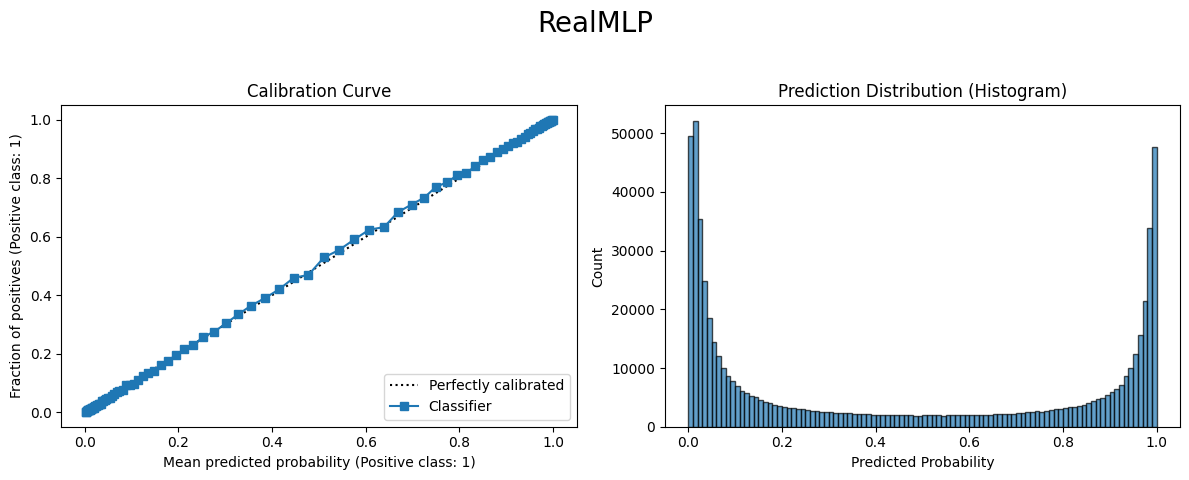

In [11]:
from sklearn.calibration import CalibrationDisplay

plt.figure(figsize=(12, 5)) 
plt.suptitle('RealMLP', fontsize=20) 

ax1 = plt.subplot(1, 2, 1)
CalibrationDisplay.from_predictions(y, oof_preds, n_bins=100, strategy='quantile', ax=ax1)
ax1.set_title('Calibration Curve')

ax2 = plt.subplot(1, 2, 2)
ax2.hist(oof_preds, bins=100, edgecolor='black', alpha=0.7)
ax2.set_title('Prediction Distribution (Histogram)')
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

# Evaluation and Submission

In [12]:
total_oof_score = roc_auc_score(y, oof_preds) 

print("\n" + "="*40)
print(f"Overall OOF ROC-AUC: {total_oof_score:.5f}")
print(f"Mean Fold Score: {np.mean(fold_scores):.5f} (+/- {np.std(fold_scores):.5f})")
print("="*40)

pd.DataFrame({'id': train['id'], 'Heart Disease_prob': oof_preds}).to_csv('oof.csv', index=False)

submission = pd.DataFrame({'id': test['id'], 'Heart Disease': test_preds})
submission.to_csv('submission.csv', index=False)
submission.head() 


Overall OOF ROC-AUC: 0.95556
Mean Fold Score: 0.95565 (+/- 0.00052)


,id,Heart Disease
0,630000,0.941543
1,630001,0.010317
2,630002,0.988423
3,630003,0.006406
4,630004,0.210430


# Baseline 
现在考虑了original的特征并加入了train作为了特征量
使用了frequency版的mlp

# Version3
增加9个医学特征量

1. "Five risk factors account for approximately 50% of the global burden of cardiovascular disease. How the presence or absence of classic risk factors affects lifetime estimates of cardiovascular disease and death from any cause remains unclear."

"Lifetime risk of cardiovascular disease and death from any cause was estimated up to 90 years of age according to the presence or absence of arterial hypertension, hyperlipidemia, underweight and overweight or obesity, diabetes, and smoking at 50 years of age. Differences in life span (in terms of additional life-years free of cardiovascular disease or death from any cause) according to the presence or absence of these risk factors were also estimated."

"The lifetime risk of cardiovascular disease was 24% (95% confidence interval [CI], 21 to 30) among women and 38% (95% CI, 30 to 45) among men for whom all five risk factors were present. In the comparison between participants with none of the risk factors and those with all the risk factors, the estimated number of additional life-years free of cardiovascular disease was 13.3 (95% CI, 11.2 to 15.7) for women and 10.6 (95% CI, 9.2 to 12.9) for men; the estimated number of additional life-years free of death was 14.5 (95% CI, 9.1 to 15.3) for women and 11.8 (95% CI, 10.1 to 13.6) for men. As compared with no changes in the presence of all risk factors, modification of hypertension at an age of 55 to less than 60 years was associated with the most additional life-years free of cardiovascular disease, and modification of smoking at an age of 55 to less than 60 years was associated with the most additional life-years free of death."

"The absence of five classic risk factors at 50 years of age was associated with more than a decade greater life expectancy than the presence of all five risk factors, in both sexes. Persons who modified hypertension and smoking in midlife had the most additional life-years free of cardiovascular disease and death from any cause, respectively." 基于这个考虑扩张特征量

2. 用lgbm+mlp的混合模型
3. 现在age,BP, Cholesterol都label embedding了，再考虑一下是不是应该保留数值呢
4. 混合模型时考虑核心 trick：裁判模型不仅看 MLP 和 CatBoost 的预测值，还看原始数据的特征（Age, Sex...）。

原理：有时候，MLP 在某些特定年龄段（比如 60-70 岁）特别准，而 CatBoost 在年轻人中特别准。如果把原始特征（Age）也喂给裁判模型，裁判就能学会：“哦，这是一个 65 岁的病人，那我要多听 MLP 的意见；如果是个年轻人，我就听 CatBoost 的。”

Broccoli Beef 的代码演示了用 StackingClassifier(..., passthrough=True) 实现了这一点，并获得了分数的微弱提升。
 
